<a href="https://colab.research.google.com/github/moushumipriya/HydroPowerRL-Reinforcement-Learning-for-Hydro-Reservoir-Management/blob/main/Reinforcement_Learning_for_Hydro_Reservoir_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
!pip install gym torch torchvision torchaudio pandas numpy matplotlib tqdm


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque, namedtuple

def generate_synthetic_inflow(start_dt, end_dt, seed=42, base_capacity=1e6):
    rng = np.random.default_rng(seed)
    hours = int((end_dt - start_dt).total_seconds() // 3600) + 1
    times = [start_dt + timedelta(hours=i) for i in range(hours)]
    day_of_year = np.array([t.timetuple().tm_yday for t in times])
    seasonal = 0.5 + 0.5 * np.sin(2 * np.pi * (day_of_year / 365.0))
    noise = rng.normal(scale=0.1, size=hours)
    storms = rng.choice([0,1], size=hours, p=[0.98, 0.02]) * rng.exponential(scale=2.0, size=hours)
    inflow = np.maximum(0.0, seasonal + 0.2*noise + storms)
    inflow_cum = inflow * base_capacity * 0.001
    df = pd.DataFrame({'inflow': inflow_cum}, index=times)
    df.index.name = 'time'
    price = (
        20
        + 5 * np.sin(2 * np.pi * (np.array([t.hour for t in times]) / 24.0))
        + 3 * np.cos(2 * np.pi * (np.array([t.timetuple().tm_yday for t in times]) / 7.0))
        + rng.normal(0, 1, size=hours)
    )
    df['price'] = np.maximum(0.1, price)
    df['hour'] = [t.hour for t in times]
    return df


In [56]:
class HydroEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, capacity=1e6, init_level_frac=0.6, min_safe_frac=0.1, max_safe_frac=0.95):
        super().__init__()
        self.df = df.reset_index()
        self.capacity = capacity
        self.init_level = capacity * init_level_frac
        self.min_safe = capacity * min_safe_frac
        self.max_safe = capacity * max_safe_frac
        self.t = 0
        self.action_space = spaces.Discrete(3)  # 3 action levels: low, medium, high release
        low = np.array([0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        high = np.array([1.0, np.finfo(np.float32).max, np.finfo(np.float32).max, 23.0], dtype=np.float32)
        self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        self.reset()

    def reset(self):
        self.t = 0
        self.level = self.init_level
        self.prev_release = 0.0
        return self._get_obs()

    def step(self, action):
        row = self.df.loc[self.t]
        inflow = float(row['inflow'])
        price = float(row['price'])
        hour = int(row['hour'])
        release_frac = {0: 0.005, 1: 0.02, 2: 0.05}[int(action)]
        release = release_frac * self.capacity
        next_level = np.clip(self.level + inflow - release, 0.0, self.capacity)

        # Calculate power and revenue
        head = 50.0  # height in meters
        rho = 1000.0  # water density kg/m3
        g = 9.81  # gravity
        eta = 0.9  # efficiency
        power_MW = eta * rho * g * release * head / 1e6
        revenue = power_MW * price

        # Penalties
        penalty = 0.0
        if next_level < self.min_safe:
            penalty -= 1e4
        if next_level > self.max_safe:
            penalty -= 5e4
        penalty -= 1e2 * abs(release - self.prev_release) / self.capacity

        reward = revenue + penalty
        self.prev_release = release
        self.level = next_level
        self.t += 1
        done = self.t >= len(self.df)
        return self._get_obs(), float(reward), done, {'revenue': revenue}

    def _get_obs(self):
        row = self.df.loc[self.t]
        inflow = float(row['inflow'])
        price = float(row['price'])
        hour = int(row['hour'])
        return np.array([self.level/self.capacity, inflow, price, hour], dtype=np.float32)

    def render(self, mode='human'):
        print(f"Step: {self.t}, Water Level: {self.level:.2f}, Prev Release: {self.prev_release:.2f}")


In [57]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class DQN(nn.Module):
    def __init__(self, obs_size, n_actions, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions)
        )
    def forward(self, x):
        return self.net(x)

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)


In [58]:
def train_dqn(env, num_episodes=100, max_steps=500, batch_size=64, gamma=0.99, lr=1e-3):
    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n

    net = DQN(obs_size, n_actions).to(device)
    target_net = DQN(obs_size, n_actions).to(device)
    target_net.load_state_dict(net.state_dict())

    optimizer = optim.Adam(net.parameters(), lr=lr)
    replay = ReplayBuffer(100000)

    epsilon = 1.0
    eps_min = 0.05
    eps_decay = 0.995
    sync_target_frames = 1000
    total_steps = 0
    all_rewards = []
    losses = []

    for ep in range(num_episodes):
        state = env.reset()
        ep_reward = 0.0
        for step in range(max_steps):
            total_steps += 1
            state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                q_vals = net(state_v)
                action = int(torch.argmax(q_vals, dim=1).item())

            next_state, reward, done, _ = env.step(action)
            replay.push(state, action, reward, next_state, done)
            ep_reward += reward
            state = next_state

            if len(replay) >= batch_size:
                batch = replay.sample(batch_size)
                states = torch.tensor(batch.state, dtype=torch.float32).to(device)
                actions = torch.tensor(batch.action, dtype=torch.int64).unsqueeze(1).to(device)
                rewards = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
                next_states = torch.tensor(batch.next_state, dtype=torch.float32).to(device)
                dones = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

                q_values = net(states).gather(1, actions)
                next_q_values = target_net(next_states).max(1)[0].unsqueeze(1).detach()
                expected_q = rewards + gamma * next_q_values * (1 - dones)

                loss = nn.functional.mse_loss(q_values, expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

            if total_steps % sync_target_frames == 0:
                target_net.load_state_dict(net.state_dict())

            if done:
                break

        epsilon = max(eps_min, epsilon * eps_decay)
        all_rewards.append(ep_reward)
        print(f"Episode {ep+1}/{num_episodes}, reward: {ep_reward:.1f}, epsilon: {epsilon:.3f}")

    return net, all_rewards, losses


                         inflow      price  hour
time                                            
2024-01-01 00:00:00  514.701020  20.476797     0
2024-01-01 01:00:00  487.806996  24.107158     1
2024-01-01 02:00:00  523.615702  24.862766     2
2024-01-01 03:00:00  527.417972  24.785485     3
2024-01-01 04:00:00  469.585974  24.618429     4
Episode 1/5, reward: 41288770.3, epsilon: 0.995
Episode 2/5, reward: 40154171.9, epsilon: 0.990
Episode 3/5, reward: 45901217.2, epsilon: 0.985
Episode 4/5, reward: 43210633.7, epsilon: 0.980
Episode 5/5, reward: 46120342.7, epsilon: 0.975


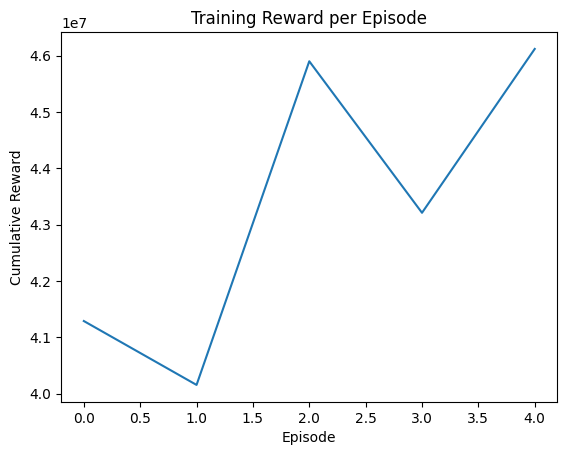

In [59]:
start_dt = datetime(2024, 1, 1)
end_dt = datetime(2024, 2, 1)  # 1 month hourly data

df = generate_synthetic_inflow(start_dt, end_dt)
print(df.head())

env = HydroEnv(df, capacity=1e6)

net, rewards, losses = train_dqn(env, num_episodes=5, max_steps=200, batch_size=32)

plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Reward per Episode')
plt.show()


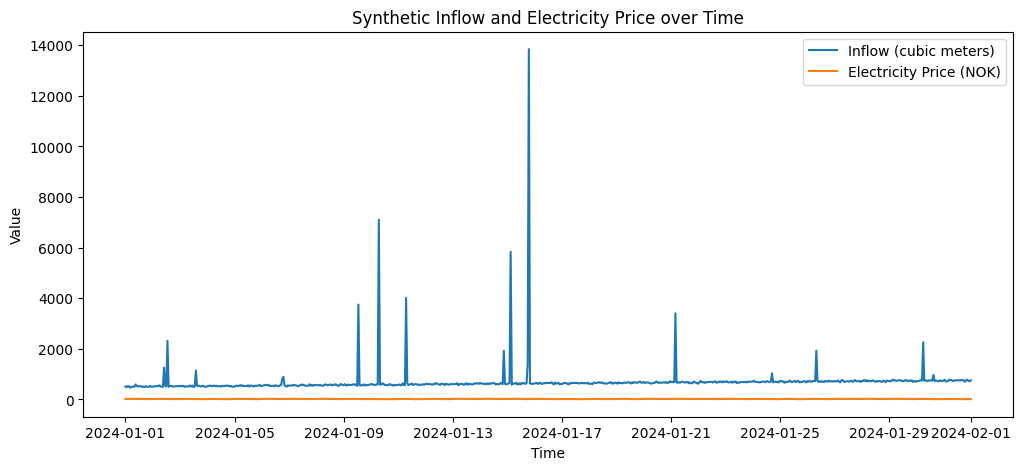

Synthetic data generated for hourly inflow and price covering 1 month.


In [60]:
plt.figure(figsize=(12,5))
plt.plot(df.index, df['inflow'], label='Inflow (cubic meters)')
plt.plot(df.index, df['price'], label='Electricity Price (NOK)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Synthetic Inflow and Electricity Price over Time')
plt.legend()
plt.show()

print("Synthetic data generated for hourly inflow and price covering 1 month.")


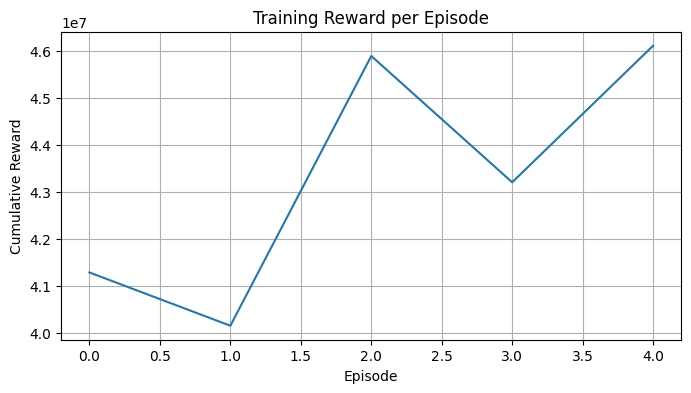

Training finished over 5 episodes.
Final episode reward: 46120342.68
Mean reward last 10 episodes: 43335027.17


In [61]:
plt.figure(figsize=(8,4))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Training Reward per Episode')
plt.grid(True)
plt.show()

print(f"Training finished over {len(rewards)} episodes.")
print(f"Final episode reward: {rewards[-1]:.2f}")
print(f"Mean reward last 10 episodes: {np.mean(rewards[-10:]):.2f}")


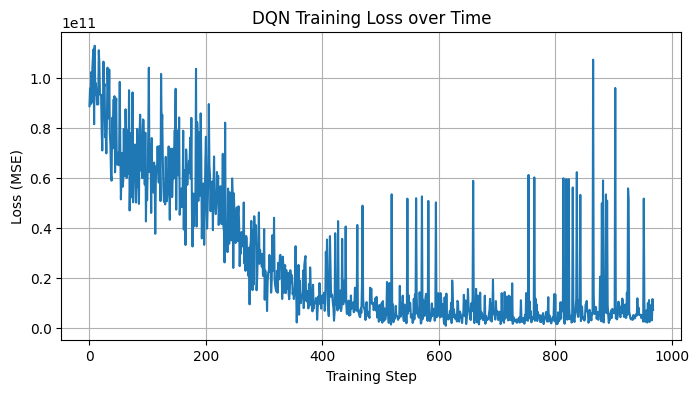

Loss shows how well the agent is learning to predict Q-values.


In [62]:
plt.figure(figsize=(8,4))
plt.plot(losses)
plt.xlabel('Training Step')
plt.ylabel('Loss (MSE)')
plt.title('DQN Training Loss over Time')
plt.grid(True)
plt.show()

print("Loss shows how well the agent is learning to predict Q-values.")


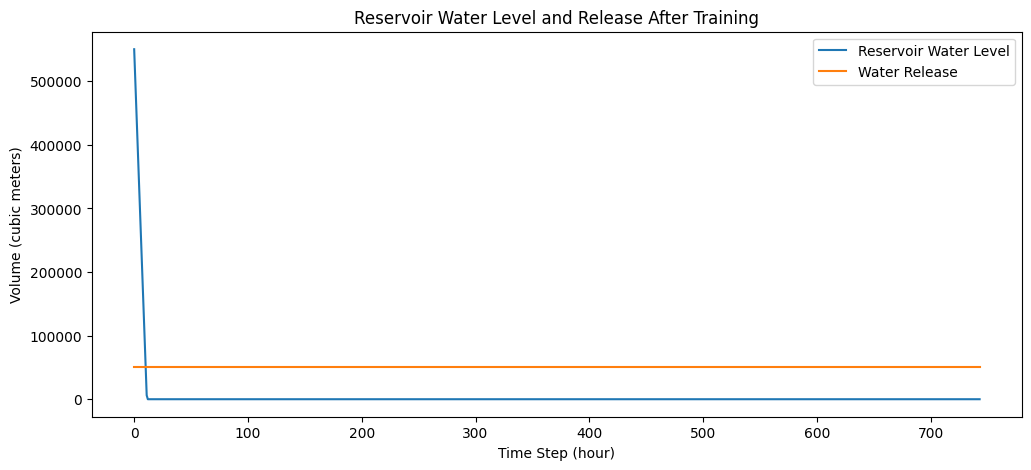

Water level and release decisions taken by trained agent over 1 month.


In [63]:
state = env.reset()
levels = []
releases = []
actions_taken = []

for _ in range(len(df)-1):
    state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
    q_vals = net(state_v)
    action = int(torch.argmax(q_vals, dim=1).item())
    _, reward, done, info = env.step(action)
    levels.append(env.level)
    releases.append(env.prev_release)
    actions_taken.append(action)
    state = env._get_obs()
    if done:
        break

plt.figure(figsize=(12,5))
plt.plot(levels, label='Reservoir Water Level')
plt.plot(releases, label='Water Release')
plt.xlabel('Time Step (hour)')
plt.ylabel('Volume (cubic meters)')
plt.title('Reservoir Water Level and Release After Training')
plt.legend()
plt.show()

print("Water level and release decisions taken by trained agent over 1 month.")


# Hydro Reservoir RL Project Summary

In this notebook, we have:

- Generated synthetic hourly inflow and electricity price data for one month.
- Created a Gym environment simulating a hydro reservoir management scenario.
- Built and trained a Deep Q-Network (DQN) agent to optimize water release decisions.
- Evaluated the agent's performance using reward and loss plots.
- Visualized the agent's reservoir management behavior after training.

This step-by-step approach demonstrates a practical application of reinforcement learning in energy management.

